# Classification of Fashion Mnist Dataset's Article Images in Different Classes: Machine Learning, Deep Learning

* [Fashion-MNIST] is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

* The dataset contains 10 labels shown in the table

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

* Goal is to make generalized model to classify images (Grayscale or Colored) in different classes for any MNIST dataset with good accuracy.

# Let's define our libraries and work on the dataset
## About Keras
- We will use Keras library for creating a convolutional neural network and train it.
- Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.
- For more information about Keras please visit https://keras.io/

In [1]:
#Start by connecting gdrive into the google colab


from google.colab import drive


drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import os
import tensorflow
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Loading Data
### We will import our dataset

In [3]:
# dataframes creation for both training and testing datasets 
train = pd.read_csv('/content/gdrive/MyDrive/fashion_mnist/fashion-mnist_train.csv',sep=',')
test = pd.read_csv('/content/gdrive/MyDrive/fashion_mnist/fashion-mnist_test.csv', sep = ',')
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
# dataframes creation for both training and testing datasets 
# train = pd.read_csv('fashion-mnist_train.csv',sep=',')
# test = pd.read_csv('fashion-mnist_test.csv', sep = ',')
# labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [6]:
print(f'Train Size: {len(train)} Test Size: {len(test)}')

Train Size: 60000 Test Size: 10000


- We have 60,000 example for training and 10,000 example for testing.

# Data Preprocessing
- Let's check our dataset for NaN values

In [7]:
train_nan = train.isna().values.sum()
test_nan = test.isna().values.sum()
print(f'Train NaN Count: {train_nan} Test NaN Count: {test_nan}')

Train NaN Count: 0 Test NaN Count: 0


There is no NaN value in our dataset

**Before using data we will reshape data for the correct input format for the Keras' CNN format and normalize data**

- We will split our data into X and y

In [8]:
X_train = train.drop('label', axis=1)
y_train = train['label']

X_test = test.drop('label', axis=1)
y_test = test['label']

In [9]:
X_train.shape

(60000, 784)

- Each sample consists of 784 pixel
- First, we need to reshape data into 3d matrices(28, 28, 1).
- Keras default data_format is channels_last. The last dimension is used for channels. In our case, we have only grayscale images. Therefore last dimension will be 1.

In [10]:
X_train = X_train.values.reshape(len(X_train), 28, 28, 1)
X_test = X_test.values.reshape(len(X_test), 28, 28, 1)

- Then we will normalize our data. Normalization helps optimization algorithms work fast.

In [11]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train /= 255 # X_train = X_train/255
X_test /= 255  # X_test = X_test/255

- Then we will convert y labels to categorical format.

In [12]:
input_shape = X_train[0].shape
category_number = len(np.unique(y_train))
y_train = tensorflow.keras.utils.to_categorical(y_train, category_number)
y_test = tensorflow.keras.utils.to_categorical(y_test, category_number)

In [13]:
X_train.shape

(60000, 28, 28, 1)

# Let's visualize some training data which is chosen randomly

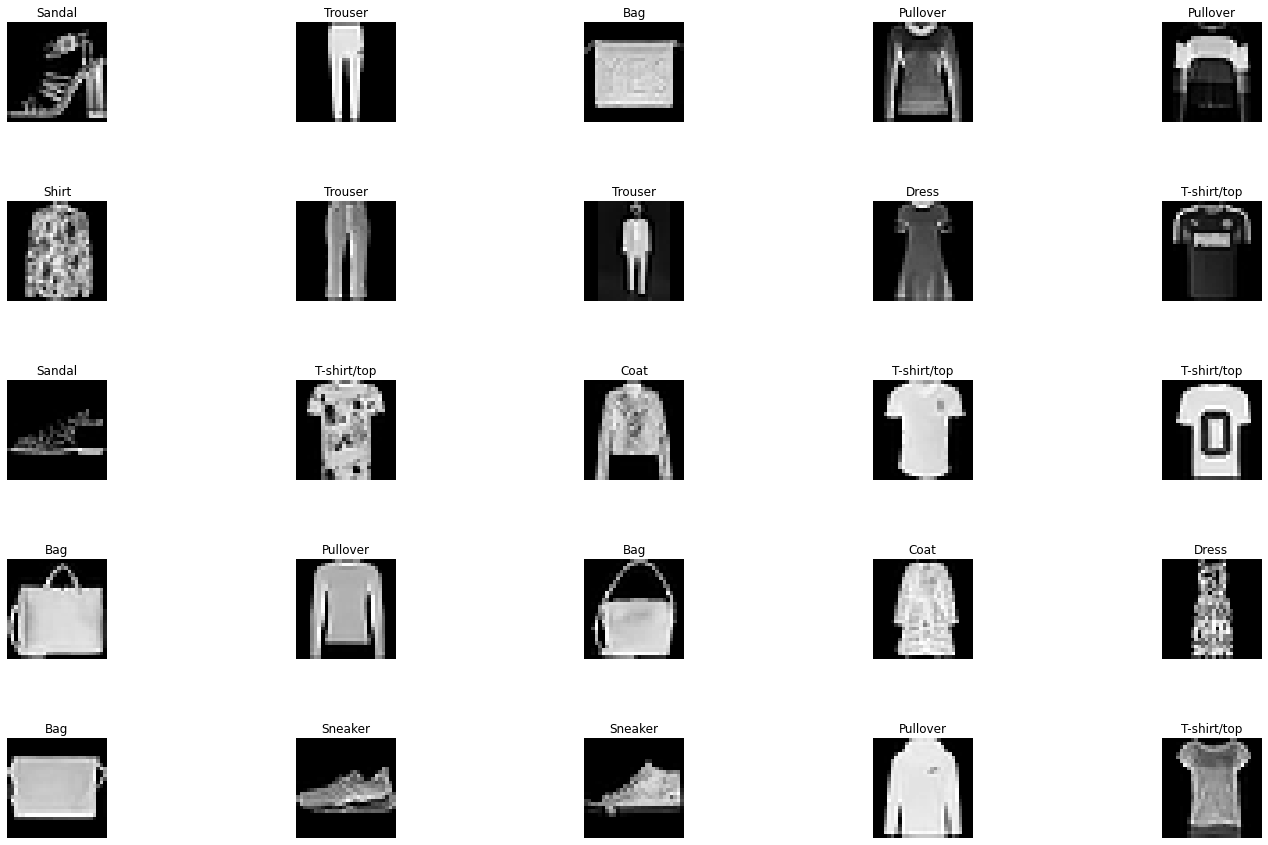

In [14]:
grid_w = 5
grid_l = 5
fig, axis = plt.subplots(grid_l, grid_w, figsize=(25, 15))
axis = axis.ravel()
for a in range(grid_l * grid_w):
    i = np.random.randint(0, len(X_train))
    axis[a].imshow(X_train[i].reshape((28, 28)), cmap='gray')
    axis[a].axis('off')
    axis[a].set_title(labels[y_train.argmax(axis=1)[i]])
plt.subplots_adjust(hspace=0.8)
plt.show()

# Creating Network Architecture

**We will use the Simplified Version of the Mini VGG network for classifying data.**
- For more information about the original VGG, you can look at the [original paper](https://arxiv.org/pdf/1409.1556v6.pdf).

In [15]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(category_number, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       7

# Training of the network

In [16]:
callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('fashion-mnist_model_weights.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.18, batch_size=128, epochs=50, shuffle=True, callbacks=[callback, checkpoint])
hist_df = pd.DataFrame(history.history) 

Epoch 1/50
385/385 [==============================] - 39s 19ms/step - loss: 1.2521 - accuracy: 0.5668 - val_loss: 2.0349 - val_accuracy: 0.3598

Epoch 00001: val_loss improved from inf to 2.03494, saving model to fashion-mnist_model_weights.hdf5
Epoch 2/50
385/385 [==============================] - 7s 18ms/step - loss: 0.5247 - accuracy: 0.8030 - val_loss: 0.3891 - val_accuracy: 0.8560

Epoch 00002: val_loss improved from 2.03494 to 0.38915, saving model to fashion-mnist_model_weights.hdf5
Epoch 3/50
385/385 [==============================] - 7s 18ms/step - loss: 0.4143 - accuracy: 0.8490 - val_loss: 0.3185 - val_accuracy: 0.8835

Epoch 00003: val_loss improved from 0.38915 to 0.31855, saving model to fashion-mnist_model_weights.hdf5
Epoch 4/50
385/385 [==============================] - 7s 18ms/step - loss: 0.3602 - accuracy: 0.8703 - val_loss: 0.2832 - val_accuracy: 0.9003

Epoch 00004: val_loss improved from 0.31855 to 0.28319, saving model to fashion-mnist_model_weights.hdf5
Epoch 5

In [17]:
model.load_weights('fashion-mnist_model_weights.hdf5')

# Plotting Learning Curves

## Loss

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

## Accuracy

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

# Model Evaluation

## Accuracy of the Test Set

In [20]:
y_test = y_test.argmax(axis=1)
accuracy_score(y_test, model.predict(X_test).argmax(axis=1))

0.9445

In [21]:
labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

----------------------Classification Report---------
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1000
           1       0.99      0.99      0.99      1000
           2       0.94      0.91      0.92      1000
           3       0.93      0.97      0.95      1000
           4       0.91      0.94      0.92      1000
           5       1.00      0.98      0.99      1000
           6       0.84      0.81      0.83      1000
           7       0.96      0.98      0.97      1000
           8       0.99      1.00      0.99      1000
           9       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1989: UserWarning:

labels size, 1000, does not match size of target_names, 10

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



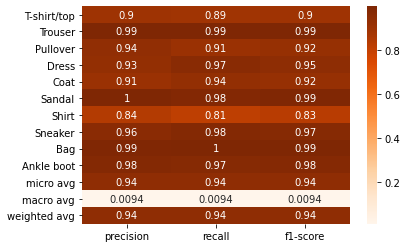

In [22]:
print("----------------------Classification Report---------")

predicted_classes = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, predicted_classes))


predicted_classes = model.predict(X_test).argmax(axis=1)
label = np.arange(1000)
target_names = list(labels)

clf_report = classification_report(y_test,
                                   predicted_classes,
                                   labels=label,
                                   target_names=target_names,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap="Oranges")


# Confusion Matrix

--------------------------------Confusion Matrix------------------------------


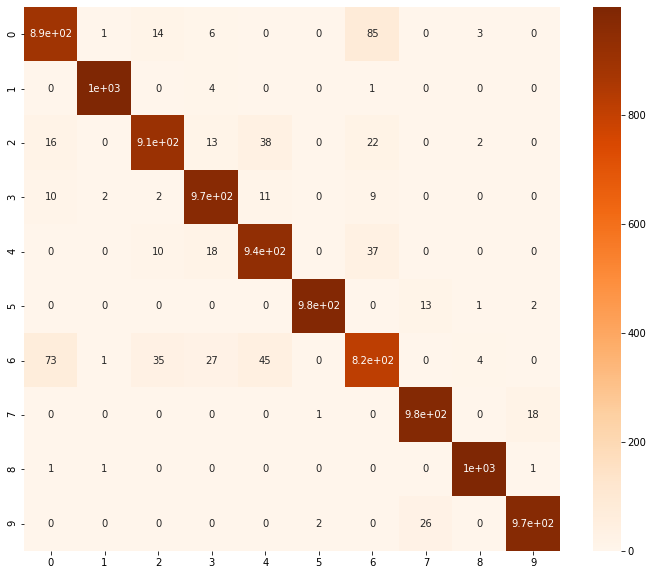

In [23]:
from sklearn.metrics import confusion_matrix

print("--------------------------------Confusion Matrix------------------------------")
predicted_classes = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_test, predicted_classes)

#class_acc = cm.diagonal() / cm.sum(axis=1)

#for i in range(len(class_acc)):
#  print(f"{labels[i]}: {class_acc[i]}")



#cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (12,10))
sns.heatmap(cm, annot=True,cmap="Oranges")

# Sum the diagonal element to get the total true correct values

In [24]:
print("--------------------------------Confusion Matrix------------------------------")
predicted_classes = model.predict(X_test).argmax(axis=1)

cm = confusion_matrix(y_test, predicted_classes)

class_acc = cm.diagonal() / cm.sum(axis=1)

for i in range(len(class_acc)):
  print(f"{labels[i]}: {class_acc[i]}")



#plt.figure(figsize = (12,10))
#sns.heatmap(cm, annot=True,cmap="Oranges")
# Sum the diagonal element to get the total true correct values

--------------------------------Confusion Matrix------------------------------
T-shirt/top: 0.891
Trouser: 0.995
Pullover: 0.909
Dress: 0.966
Coat: 0.935
Sandal: 0.984
Shirt: 0.815
Sneaker: 0.981
Bag: 0.997
Ankle boot: 0.972


##  Class-Based accuracy of the Test Set



# Let's plot some misclassified samples

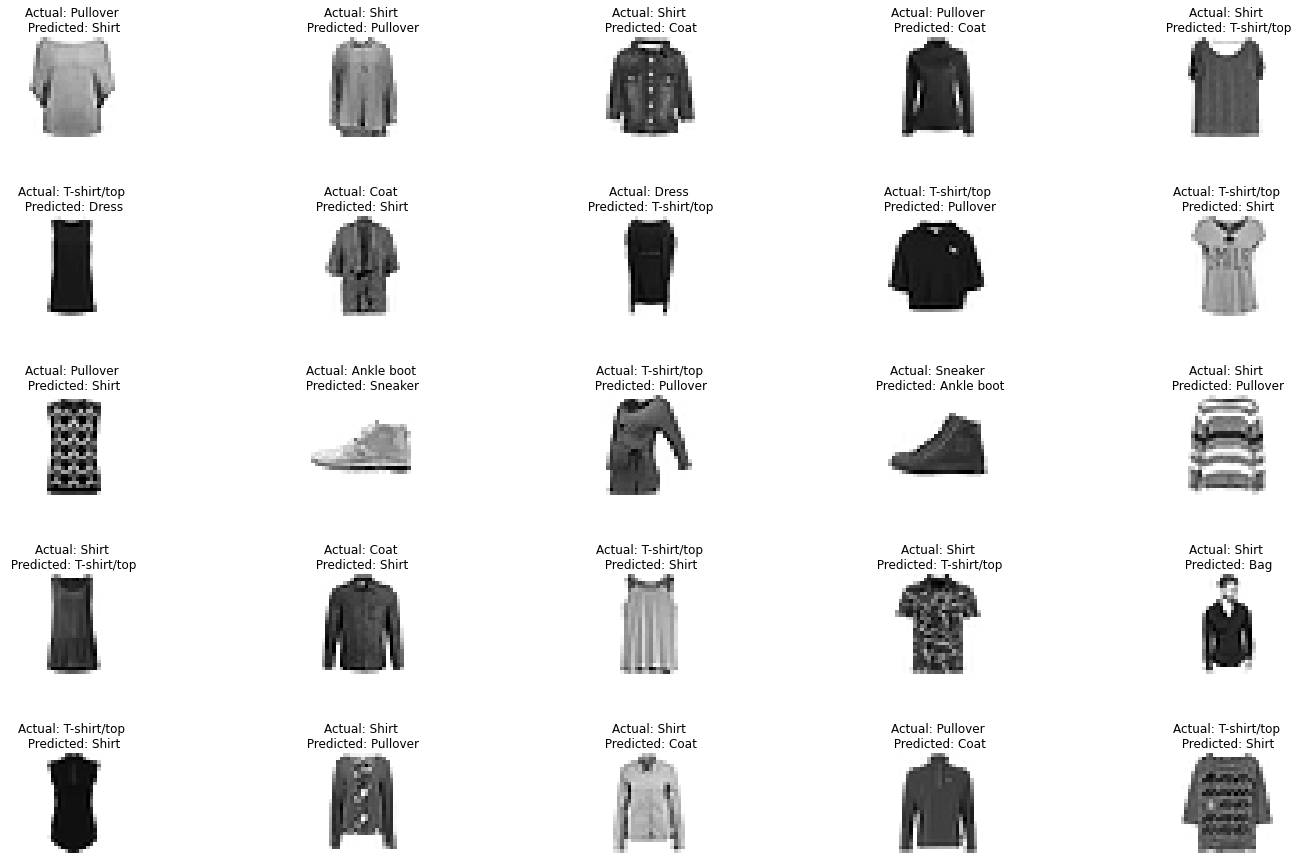

In [25]:
grid_w = 5
grid_l = 5
fig, axis = plt.subplots(grid_l, grid_w, figsize=(25, 15))
predicted_classes = model.predict(X_test).argmax(axis=1)
axis = axis.ravel()
k=0
mis_cls=[i for i in range(len(predicted_classes)) if predicted_classes[i]!=y_test[i]]
for a in range(grid_l * grid_w):
    i = mis_cls[k]
    k+=1
    axis[a].imshow(X_test[i].reshape((28, 28)), cmap=plt.cm.binary)
    axis[a].axis('off')
    axis[a].set_title(f"Actual: {labels[y_test[i]]}\n Predicted: {labels[predicted_classes[i]]}")
plt.subplots_adjust(hspace=0.8)
plt.show()

# Let's visualize some of the predictions with probabilities

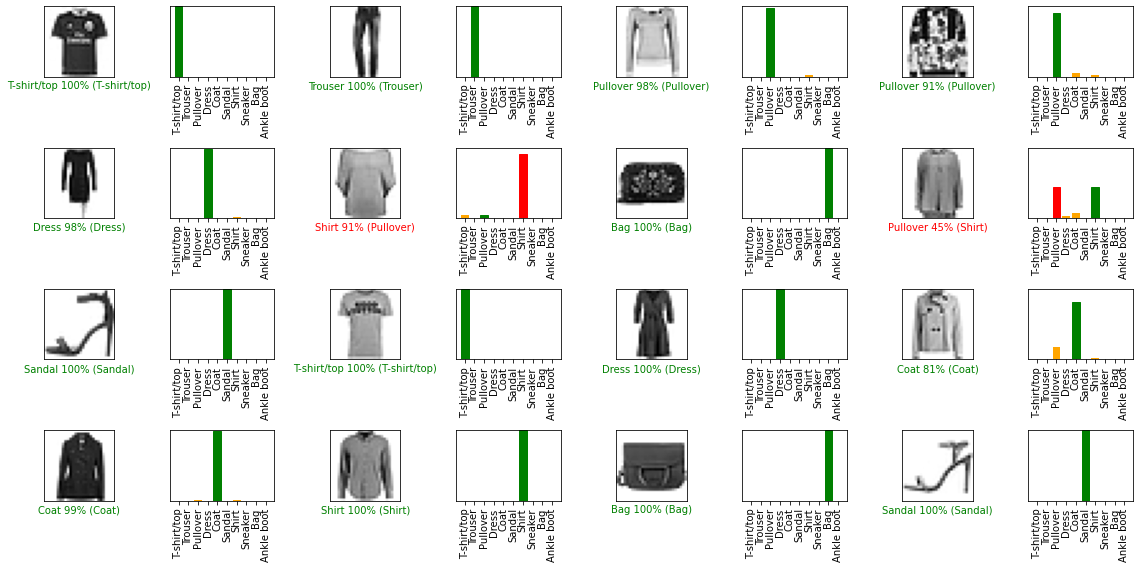

In [26]:
# This visualization part is taken from https://www.tensorflow.org/tutorials/keras/classification#verify_predictions
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape((28, 28)), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label], 100*np.max(predictions_array), labels[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10), labels, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#FFA500")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

    
predictions = model.predict(X_test)
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

# Conclusion

## We classified Fashion MNIST using CNN with Keras as high level API of Tensorflow Framework and got 94% test accuracy.


In [27]:
import tensorflow as tf
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

# Save Model

- We now need to save our trained model and it has to be saved in a SavedModel format.
- The model will have a version number and will be saved in a structured directory 
- tf.saved_model.simple_save is a function used to build a saved model that is suitable for serving using Tensorflow Serving. 
- After the model is saved, we can now use TensorFlow Serving to start making inference requests using a specific version of our trained model "servable".
- Use SavedModel to save and load your model—variables, the graph, and the graph's metadata. 
- This is a language-neutral, recoverable, hermetic serialization format that enables higher-level systems and tools to produce, consume, and transform TensorFlow models.
- simple_save offers a very easy way to save a model as follows: 

  - simple_save(session,
            export_dir,
            inputs={"x": x, "y": y},
            outputs={"z": z})
            
- Check this out for more information: 
https://www.tensorflow.org/guide/saved_model

In [28]:
# Let's obtain a temporary storage directory
MODEL_DIR = tempfile.gettempdir()

In [29]:
MODEL_DIR

'/tmp'

In [30]:
# Let's specify the model version, choose #1 for now 
version = 1 

In [31]:
# Let's join the temp model directory with our chosen version number 
# The expected result will be = '\tmp\version number'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [32]:
import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))
print("Keras version: {}".format(tf.keras.__version__))

TensorFlow version: 2.4.1
Keras version: 2.4.0


In [33]:
# Import Keras that uses TensorFlow as backend.

# Importing specific module from scikit learn to split the dataset

import tensorflow as tf
import keras



In [34]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [35]:
# Let's save the model using simple_save
# If the directory already exists, we will remove it using '!rm' 
# rm removes each file specified on the command line. 

if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.compat.v1.saved_model.simple_save(
    tf.compat.v1.keras.backend.get_session(),
    export_path,
    inputs={'input_image': model.input},
    outputs={t.name:t for t in model.outputs})


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/1/saved_model.pb


In [36]:
!ls -l {export_path}

total 8
-rw-r--r-- 1 root root  229 Apr 26 04:56 saved_model.pb
drwxr-xr-x 2 root root 4096 Apr 26 04:56 variables




## EXPLORE THE SAVED MODEL

- saved_model_cli will be used to explore MetaGraphDefs (the models) and SignatureDefs (the methods you can call) in our SavedModel. 
- A MetaGraph is a dataflow graph, plus its associated variables, assets, and signatures. 
- A signature is the set of inputs to and outputs from a graph.

In [37]:
# Now we can view our saved model # Architeture of the model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: conv2d_input
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2/Softmax:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: dense_2/Softmax:0
  Method name is: tensorflow/serving/predict


## SERVING MODEL USING TENSORFLOW SERVING

## Adding tensorflow-model-server package to our list of packages 

In [38]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  37253      0 --:--:-- --:--:-- --:--:-- 37253
OK
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Re

## Installing tensorflow model server:

In [39]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.0 [326 MB]
Fetched 326 MB in 4s (81.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.0_all.deb ...
Unpacking tensorflow-model-server (2.5.0) ...
Setting up tensorflow-model-server (2.5.0) ...


## Running TensorFlow Serving

- We will load our model and start making inferences (predictions) based on it.
- There are some important parameters:

  - rest_api_port: The port that you'll use for REST requests.
  - model_name: You'll use this in the URL of REST requests. You can choose any name
  - model_base_path: This is the path to the directory where you've saved your model.
  
- For more information regarding REST, check this out: 
https://www.codecademy.com/articles/what-is-rest
- REST is a revival of HTTP in which http commands have semantic meaning. 

In [40]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [41]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 0 in a separate thread.


In [42]:
!tail server.log

## Making requests in TensorFlow Serving

In [43]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28))
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


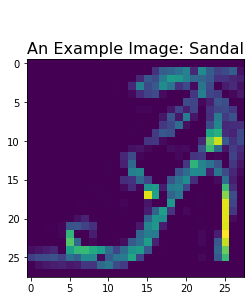

In [47]:
rando = random.randint(0,len(X_test)-1)
show(rando, 'An Example Image: {}'.format(labels[y_test[rando]]))